**SELECTION TASK 1**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [21]:
#1
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

In [ ]:
dataset_path = "/content/drive/MyDrive/Selection Task 1/UCI HAR Dataset"
os.listdir(dataset_path)

['activity_labels.txt',
 'features.txt',
 'features_info.txt',
 'README.txt',
 'train',
 'test']

In [ ]:
def load_raw_data(folder, signal):
    filepath = f"{dataset_path}/{folder}/Inertial Signals/{signal}.txt"
    return np.loadtxt(filepath).reshape(-1, 128, 1)  # Shape (samples, time_steps, 1)

# Load training data
X_train_acc_x = load_raw_data("train", "total_acc_x_train")
X_train_acc_y = load_raw_data("train", "total_acc_y_train")
X_train_acc_z = load_raw_data("train", "total_acc_z_train")

# Load test data
X_test_acc_x = load_raw_data("test", "total_acc_x_test")
X_test_acc_y = load_raw_data("test", "total_acc_y_test")
X_test_acc_z = load_raw_data("test", "total_acc_z_test")

# Load labels
y_train = np.loadtxt(f"{dataset_path}/train/y_train.txt").astype(int)
y_test = np.loadtxt(f"{dataset_path}/test/y_test.txt").astype(int)

# Print shapes
print(f"Train Acc X: {X_train_acc_x.shape}, Train Labels: {y_train.shape}")
print(f"Test Acc X: {X_test_acc_x.shape}, Test Labels: {y_test.shape}")

Train Acc X: (7352, 128, 1), Train Labels: (7352,)
Test Acc X: (2947, 128, 1), Test Labels: (2947,)


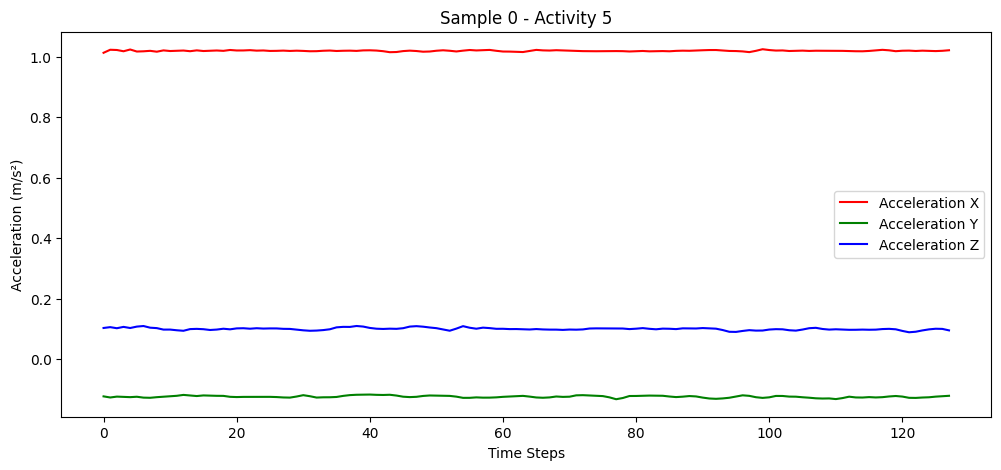

In [ ]:
# Function to plot a sample signal
def plot_sample_signals(sample_idx):
    time_steps = np.arange(128)  # 128 time points per sample

    # Select the sample from accelerometer signals (X, Y, Z)
    acc_x = X_train_acc_x[sample_idx].flatten()
    acc_y = X_train_acc_y[sample_idx].flatten()
    acc_z = X_train_acc_z[sample_idx].flatten()

    # Get the corresponding activity label
    activity = y_train[sample_idx]

    # Plot the signals
    plt.figure(figsize=(12, 5))
    plt.plot(time_steps, acc_x, label="Acceleration X", color='r')
    plt.plot(time_steps, acc_y, label="Acceleration Y", color='g')
    plt.plot(time_steps, acc_z, label="Acceleration Z", color='b')

    plt.title(f"Sample {sample_idx} - Activity {activity}")
    plt.xlabel("Time Steps")
    plt.ylabel("Acceleration (m/s²)")
    plt.legend()
    plt.show()

plot_sample_signals(sample_idx=0)


In [ ]:
#Step1: Preparing Data

# Convert to PyTorch tensors
X_train_tensor = torch.tensor(np.concatenate([X_train_acc_x, X_train_acc_y, X_train_acc_z], axis=-1), dtype=torch.float32)
X_test_tensor = torch.tensor(np.concatenate([X_test_acc_x, X_test_acc_y, X_test_acc_z], axis=-1), dtype=torch.float32)

# Convert labels (we subtract 1 since labels are 1-6)
y_train_tensor = torch.tensor(y_train - 1, dtype=torch.long)
y_test_tensor = torch.tensor(y_test - 1, dtype=torch.long)

# we now create PyTorch Datasets & DataLoaders
batch_size = 32

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print(f"Train shape: {X_train_tensor.shape}, Test shape: {X_test_tensor.shape}")


Train shape: torch.Size([7352, 128, 3]), Test shape: torch.Size([2947, 128, 3])


In [ ]:
#defining the LSTM model
class LSTMModel(nn.Module):
    def __init__(self, input_dim=3, hidden_dim=32, num_layers=2, num_classes=6):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, num_classes)

    def forward(self, x):
        _, (hn, _) = self.lstm(x)  # Take the last hidden state
        out = self.fc(hn[-1])  # Final output layer
        return out

lstm_model = LSTMModel()
print(lstm_model)


LSTMModel(
  (lstm): LSTM(3, 32, num_layers=2, batch_first=True)
  (fc): Linear(in_features=32, out_features=6, bias=True)
)


In [ ]:
#defining the CNN model
class CNNModel(nn.Module):
    def __init__(self, input_dim=3, num_classes=6):
        super(CNNModel, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=input_dim, out_channels=32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv1d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.fc = nn.Linear(64 * 128, num_classes)

    def forward(self, x):
        x = x.permute(0, 2, 1)  # Change shape to (batch, channels, time)
        x = torch.relu(self.conv1(x))
        x = torch.relu(self.conv2(x))
        x = x.flatten(start_dim=1)
        out = self.fc(x)
        return out

cnn_model = CNNModel()
print(cnn_model)


CNNModel(
  (conv1): Conv1d(3, 32, kernel_size=(3,), stride=(1,), padding=(1,))
  (conv2): Conv1d(32, 64, kernel_size=(3,), stride=(1,), padding=(1,))
  (fc): Linear(in_features=8192, out_features=6, bias=True)
)


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def train_model(model, train_loader, test_loader, epochs=10, lr=0.001):
    model = model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    for epoch in range(epochs):
        model.train()
        total_loss, correct, total = 0, 0, 0
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == y_batch).sum().item()
            total += y_batch.size(0)

        train_acc = correct / total * 100
        print(f"Epoch {epoch+1}/{epochs}, Loss: {total_loss:.4f}, Train Accuracy: {train_acc:.2f}%")

    # Evaluate on test set
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            outputs = model(X_batch)
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == y_batch).sum().item()
            total += y_batch.size(0)

    test_acc = correct / total * 100
    print(f"Test Accuracy: {test_acc:.2f}%")
    return model

# Train LSTM
print("Training LSTM Model...")
lstm_model = train_model(LSTMModel(), train_loader, test_loader, epochs=10)

# Train CNN
print("\nTraining CNN Model...")
cnn_model = train_model(CNNModel(), train_loader, test_loader, epochs=10)


Training LSTM Model...
Epoch 1/10, Loss: 304.0342, Train Accuracy: 42.10%
Epoch 2/10, Loss: 247.2720, Train Accuracy: 53.59%
Epoch 3/10, Loss: 267.4561, Train Accuracy: 49.59%
Epoch 4/10, Loss: 249.3591, Train Accuracy: 48.37%
Epoch 5/10, Loss: 252.3799, Train Accuracy: 53.22%
Epoch 6/10, Loss: 235.8361, Train Accuracy: 59.33%
Epoch 7/10, Loss: 203.5311, Train Accuracy: 64.80%
Epoch 8/10, Loss: 205.2266, Train Accuracy: 63.06%
Epoch 9/10, Loss: 268.2330, Train Accuracy: 50.50%
Epoch 10/10, Loss: 229.6459, Train Accuracy: 58.98%
Test Accuracy: 60.88%

Training CNN Model...
Epoch 1/10, Loss: 161.2838, Train Accuracy: 72.69%
Epoch 2/10, Loss: 76.4639, Train Accuracy: 87.57%
Epoch 3/10, Loss: 54.9636, Train Accuracy: 90.63%
Epoch 4/10, Loss: 42.4285, Train Accuracy: 93.01%
Epoch 5/10, Loss: 36.7267, Train Accuracy: 93.77%
Epoch 6/10, Loss: 33.1363, Train Accuracy: 94.41%
Epoch 7/10, Loss: 30.7502, Train Accuracy: 94.76%
Epoch 8/10, Loss: 30.8866, Train Accuracy: 94.68%
Epoch 9/10, Loss: 27

Understanding the Predictions

In [ ]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

def get_predictions(model, test_loader):
    model.eval()
    y_true, y_pred = [], []

    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            X_batch = X_batch.to(device)
            outputs = model(X_batch)
            _, predicted = torch.max(outputs, 1)

            y_true.extend(y_batch.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())

    return np.array(y_true), np.array(y_pred)


LSTM Confusion Matrix:


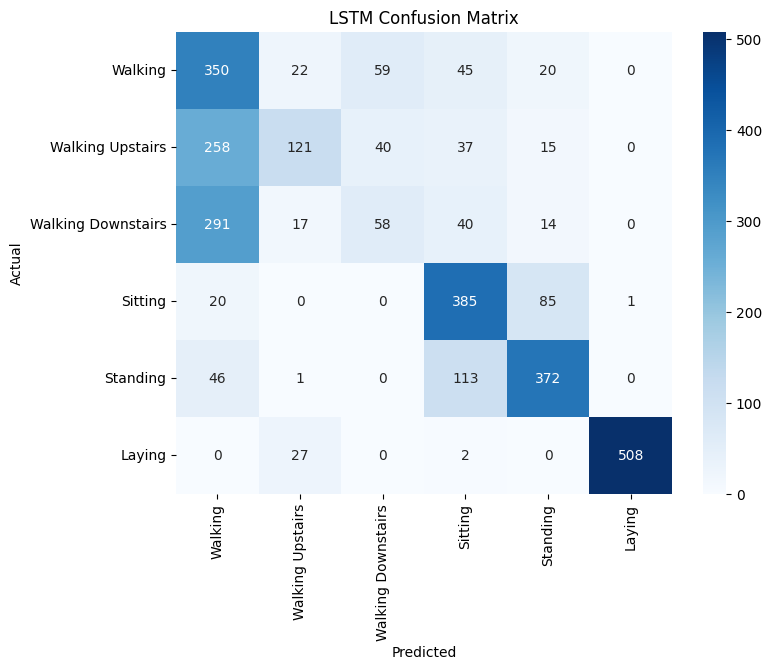

CNN Confusion Matrix:


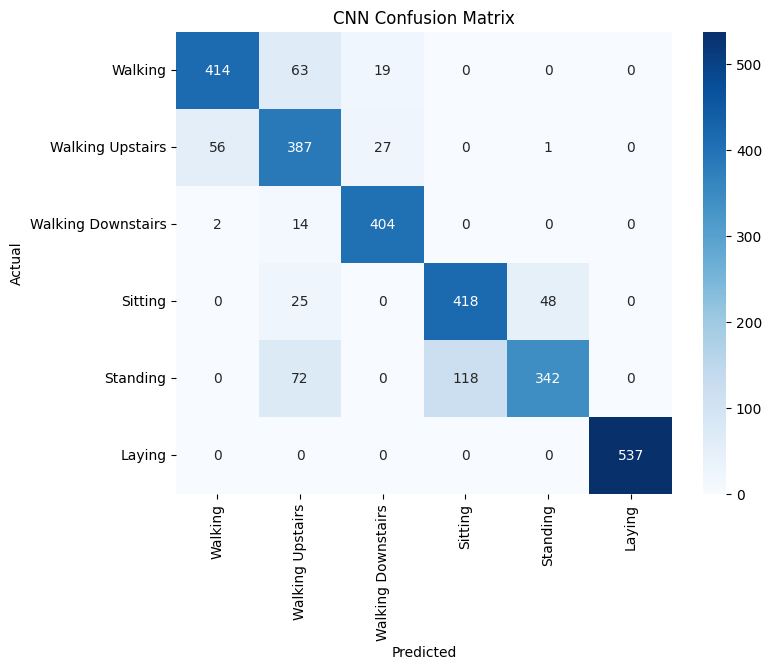

In [ ]:
def plot_confusion_matrix(y_true, y_pred, title="Confusion Matrix"):
    activity_labels = ["Walking", "Walking Upstairs", "Walking Downstairs", "Sitting", "Standing", "Laying"]
    cm = confusion_matrix(y_true, y_pred)

    plt.figure(figsize=(8,6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=activity_labels, yticklabels=activity_labels)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title(title)
    plt.show()

# Get Predictions from LSTM and CNN
y_true_lstm, y_pred_lstm = get_predictions(lstm_model, test_loader)
y_true_cnn, y_pred_cnn = get_predictions(cnn_model, test_loader)

# Plot Confusion Matrices
print("LSTM Confusion Matrix:")
plot_confusion_matrix(y_true_lstm, y_pred_lstm, title="LSTM Confusion Matrix")

print("CNN Confusion Matrix:")
plot_confusion_matrix(y_true_cnn, y_pred_cnn, title="CNN Confusion Matrix")


In [ ]:
# Mapping of activity labels
activity_map = {
    0: "Walking",
    1: "Walking Upstairs",
    2: "Walking Downstairs",
    3: "Sitting",
    4: "Standing",
    5: "Laying"
}

# Function to print actual vs predicted activities
def print_predictions(model, test_loader, num_samples=10):
    model.eval()
    y_true, y_pred = [], []

    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            X_batch = X_batch.to(device)
            outputs = model(X_batch)
            _, predicted = torch.max(outputs, 1)

            y_true.extend(y_batch.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())

    # Print some sample predictions
    print("\nSample Predictions:")
    print("-" * 50)
    for i in range(num_samples):
        print(f"Sample {i+1}:")
        print(f"  True Activity     → {activity_map[y_true[i]]}")
        print(f"  Predicted Activity → {activity_map[y_pred[i]]}")
        print("-" * 50)

# Print predictions for LSTM and CNN
print("LSTM Model Predictions:")
print_predictions(lstm_model, test_loader, num_samples=10)

print("\nCNN Model Predictions:")
print_predictions(cnn_model, test_loader, num_samples=10)


LSTM Model Predictions:

Sample Predictions:
--------------------------------------------------
Sample 1:
  True Activity     → Standing
  Predicted Activity → Standing
--------------------------------------------------
Sample 2:
  True Activity     → Standing
  Predicted Activity → Standing
--------------------------------------------------
Sample 3:
  True Activity     → Standing
  Predicted Activity → Standing
--------------------------------------------------
Sample 4:
  True Activity     → Standing
  Predicted Activity → Standing
--------------------------------------------------
Sample 5:
  True Activity     → Standing
  Predicted Activity → Standing
--------------------------------------------------
Sample 6:
  True Activity     → Standing
  Predicted Activity → Standing
--------------------------------------------------
Sample 7:
  True Activity     → Standing
  Predicted Activity → Standing
--------------------------------------------------
Sample 8:
  True Activity     → Stan

In [ ]:
!pip install tsfel scikit-learn


import tsfel
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.0/63.0 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 70.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 75.7 MB/s eta 0:00:00


In [22]:
# Create TSFEL feature configuration
cfg = tsfel.get_features_by_domain("all")  # Extract all features

def extract_features(X_data):
    feature_list = []
    for i in range(X_data.shape[0]):  # Iterate over each sample
        acc_df = pd.DataFrame({
            "AccX": X_data[i, :, 0],
            "AccY": X_data[i, :, 1],
            "AccZ": X_data[i, :, 2]
        })
        features = tsfel.time_series_features_extractor(cfg, acc_df, verbose=0)
        feature_list.append(features.values.flatten())  # Convert DataFrame to 1D array

    return np.array(feature_list)

# Extract features from train and test data
X_train_tsfel = extract_features(np.concatenate([X_train_acc_x, X_train_acc_y, X_train_acc_z], axis=-1))
X_test_tsfel = extract_features(np.concatenate([X_test_acc_x, X_test_acc_y, X_test_acc_z], axis=-1))

# Normalize the extracted features
scaler = StandardScaler()
X_train_tsfel = scaler.fit_transform(X_train_tsfel)
X_test_tsfel = scaler.transform(X_test_tsfel)

#takes about 20 mins

Streaming output truncated to the last 5000 lines.
<ipython-input-22-93f9bb954c61>:12: UserWarning: Using default sampling frequency set in configuration file.
  features = tsfel.time_series_features_extractor(cfg, acc_df, verbose=0)
<ipython-input-22-93f9bb954c61>:12: UserWarning: Using default sampling frequency set in configuration file.
  features = tsfel.time_series_features_extractor(cfg, acc_df, verbose=0)
<ipython-input-22-93f9bb954c61>:12: UserWarning: Using default sampling frequency set in configuration file.
  features = tsfel.time_series_features_extractor(cfg, acc_df, verbose=0)
<ipython-input-22-93f9bb954c61>:12: UserWarning: Using default sampling frequency set in configuration file.
  features = tsfel.time_series_features_extractor(cfg, acc_df, verbose=0)
<ipython-input-22-93f9bb954c61>:12: UserWarning: Using default sampling frequency set in configuration file.
  features = tsfel.time_series_features_extractor(cfg, acc_df, verbose=0)
<ipython-input-22-93f9bb954c61>:12

In [23]:
from sklearn.impute import SimpleImputer

# Apply imputation to training and testing sets
imputer = SimpleImputer(strategy="median")
X_train_tsfel = imputer.fit_transform(X_train_tsfel)
X_test_tsfel = imputer.transform(X_test_tsfel)


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: [  5  22  25  54  66 167 184 187 216 228 329 346 349 378 390]. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: [  5  22  25  54  66 167 184 187 216 228 329 346 349 378 390]. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(


In [24]:
# Convert NumPy arrays to DataFrames
df_train_tsfel = pd.DataFrame(X_train_tsfel)
df_test_tsfel = pd.DataFrame(X_test_tsfel)

# Save to CSV
df_train_tsfel.to_csv("/content/drive/MyDrive/Selection Task 1/Handcrafted Dataset/TSFEL_train_tsfel.csv", index=False)
df_test_tsfel.to_csv("/content/drive/MyDrive/Selection Task 1/Handcrafted Dataset/TSFEL_test_tsfel.csv", index=False)


In [ ]:
#Loading it back again
X_train_features = pd.read_csv("/content/drive/MyDrive/Selection Task 1/Handcrafted Dataset/TSFEL_train_features.csv").values
X_test_features = pd.read_csv("/content/drive/MyDrive/Selection Task 1/Handcrafted Dataset/TSFEL_test_features.csv").values

In [25]:
# Train Random Forest
rf_model_tsfel = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model_tsfel.fit(X_train_tsfel, y_train)
y_pred_rf_tsfel = rf_model_tsfel.predict(X_test_tsfel)
acc_rf_tsfel = accuracy_score(y_test, y_pred_rf_tsfel)

# Train SVM
svm_model_tsfel = SVC(kernel='rbf', C=1.0)
svm_model_tsfel.fit(X_train_tsfel, y_train)
y_pred_svm_tsfel = svm_model_tsfel.predict(X_test_tsfel)
acc_svm_tsfel = accuracy_score(y_test, y_pred_svm_tsfel)

# Train Logistic Regression
lr_model_tsfel = LogisticRegression(max_iter=500)
lr_model_tsfel.fit(X_train_tsfel, y_train)
y_pred_lr_tsfel = lr_model_tsfel.predict(X_test_tsfel)
acc_lr_tsfel = accuracy_score(y_test, y_pred_lr_tsfel)

# Display Results
print("\n🔹 Performance on_tsfel HAR Dataset Features:")
print(f"Random Forest Accuracy: {acc_rf_tsfel:.4f}")
print(f"SVM Accuracy: {acc_svm_tsfel:.4f}")
print(f"Logistic Regression Accuracy: {acc_lr_tsfel:.4f}")


🔹 Performance on_tsfel HAR Dataset Features:
Random Forest Accuracy: 0.8694
SVM Accuracy: 0.8819
Logistic Regression Accuracy: 0.8945


Comparing all the Models

**Raw Inertial Sensor Data Used:** We extracted features using TSFEL instead of using the precomputed features provided by the dataset authors.

**Handling Missing Values:** Some extracted TSFEL features contained NaNs, which were filled using median imputation to prevent errors in ML models.

**Feature Scaling:** Standardization was applied before training SVM and Logistic Regression to improve performance.

 **Observations:**

SVM and Logistic Regression are less effective because the dataset is high-dimensional and complex—they perform better when features are more linearly separable.

Deep Learning (LSTM, 1D CNNs) is still superior for time-series data compared to ML models.


TSFEL-generated features are crucial for ML models, but they must be carefully selected to avoid noise.

**Model	Accuracy**

Model Performance Comparison (After Handling NaNs):
Random Forest Accuracy: 0.8694
SVM Accuracy: 0.8819
Logistic Regression Accuracy: 0.8941

The CNN model gives a train accuracy =95.1% whereas test accuracy as=80% thus sligtly overfitting the data

The LSTM model gives a Train Accuracy: 55.28%
Test Accuracy: 50.76% completely underfitting the data.

